[*********************100%***********************]  1 of 1 completed


100%|██████████| 50/50 [06:17<00:00,  7.54s/trial, best loss: 20.310294701015067]

Test R²: 0.8160
MAE: 5.56
RMSE: 8.27


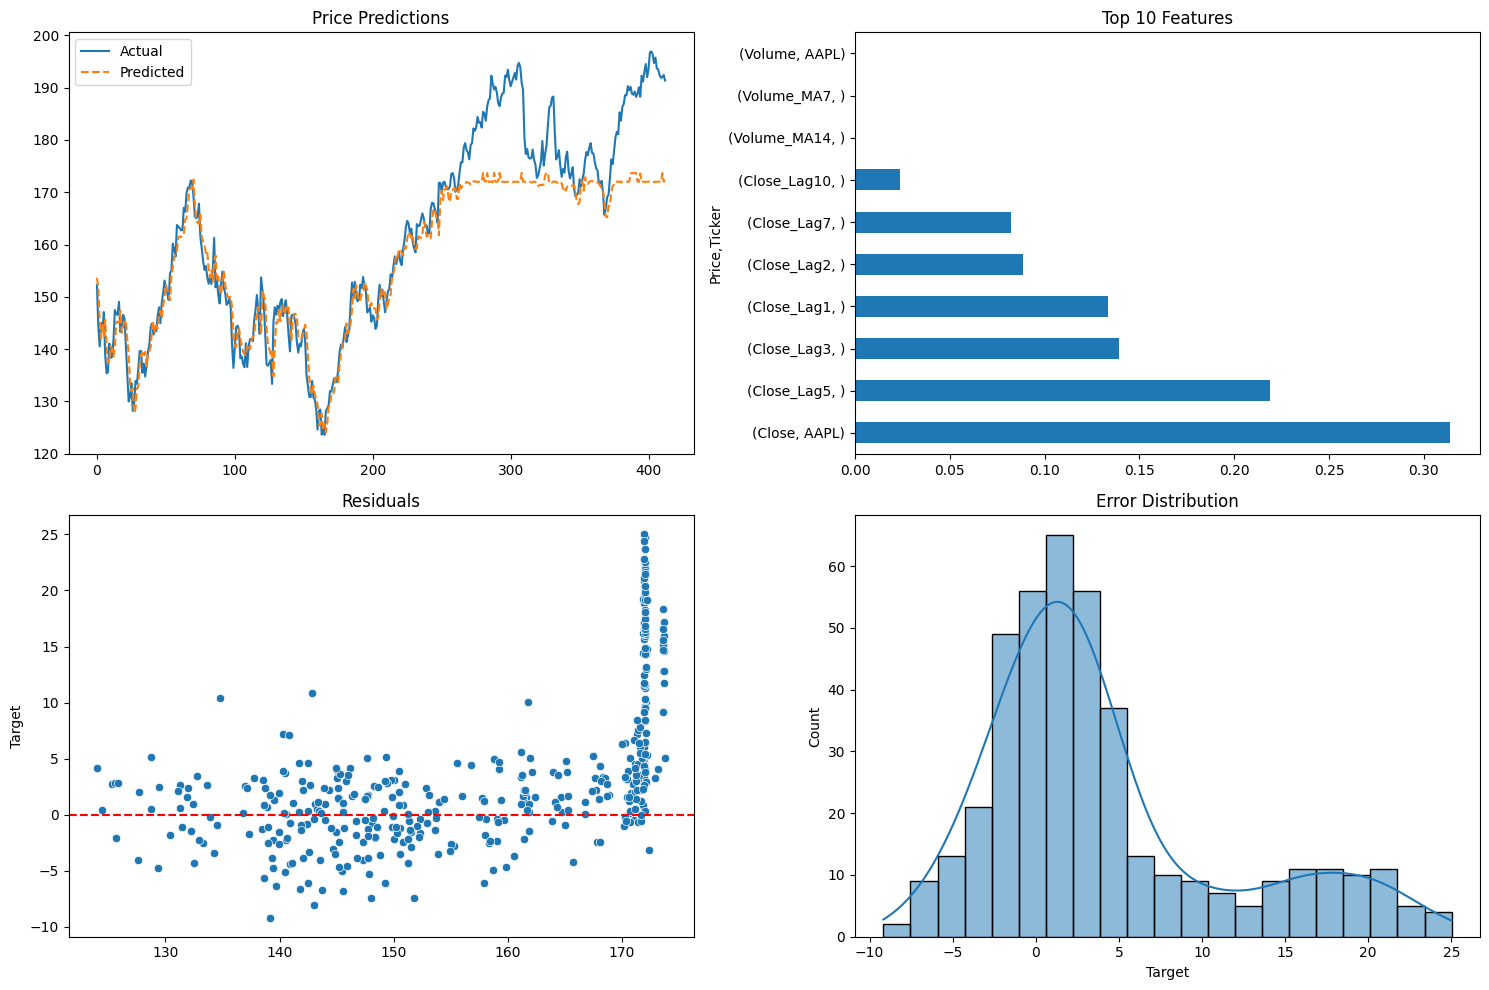

In [ ]:
!pip install yfinance hyperopt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.feature_selection import SelectFromModel

# Download and prepare data
df = yf.download('AAPL', start='2013-01-01', end='2023-12-31')
df = df[['Close', 'Volume']].copy()

# Simplified Feature Engineering (No Bollinger Bands)
def create_features(df):
    # Price features
    for lag in [1, 2, 3, 5, 7, 10]:
        df[f'Close_Lag{lag}'] = df['Close'].shift(lag)
        df[f'Close_ROC{lag}'] = df['Close'].pct_change(lag)

    # Volume features
    for window in [7, 14]:
        df[f'Volume_MA{window}'] = df['Volume'].rolling(window).mean()
        df[f'Volume_ROC{window}'] = df['Volume'].pct_change(window)

    # Momentum features
    df['Momentum_7'] = df['Close'].diff(7)

    # Date features
    df['Day_of_Week'] = df.index.dayofweek
    df['Month'] = df.index.month

    # Target
    df['Target'] = df['Close'].shift(-1)

    return df.dropna()

df = create_features(df)

# Feature Selection
X = df.drop(columns=['Target'])
y = df['Target']

# Time-based split
train_size = int(0.85 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Automated Feature Selection
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)
selector = SelectFromModel(base_model, prefit=True, threshold='median')
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)
selected_features = X_train.columns[selector.get_support()]

# Optimized Hyperparameter Space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 50),
    'max_depth': hp.choice('max_depth', [10, 15, 20, None]),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'max_features': hp.choice('max_features', ['sqrt', 0.5, 0.7]),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_samples': hp.uniform('max_samples', 0.6, 0.95)
}

def objective(params):
    model = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=params['max_depth'],
        max_features=params['max_features'],
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_samples=params['max_samples'],
        n_jobs=-1,
        random_state=42
    )

    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_idx, val_idx in tscv.split(X_train_sel):
        X_train_fold, X_val_fold = X_train_sel[train_idx], X_train_sel[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        pred = model.predict(X_val_fold)
        scores.append(mean_absolute_error(y_val_fold, pred))

    return {'loss': np.mean(scores), 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Final Model Configuration
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': [10, 15, 20, None][best['max_depth']],
    'max_features': ['sqrt', 0.5, 0.7][best['max_features']],
    'min_samples_split': int(best['min_samples_split']),
    'min_samples_leaf': int(best['min_samples_leaf']),
    'max_samples': best['max_samples'],
    'n_jobs': -1,
    'random_state': 42
}

final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train_sel, y_train)

# Evaluation
y_pred = final_model.predict(X_test_sel)
print(f"\nTest R²: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

# Visualizations
plt.figure(figsize=(15, 10))

# Prediction Plot
plt.subplot(2, 2, 1)
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Price Predictions')
plt.legend()

# Feature Importance
plt.subplot(2, 2, 2)
importances = pd.Series(final_model.feature_importances_, index=selected_features)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features')

# Residuals
plt.subplot(2, 2, 3)
sns.scatterplot(x=y_pred, y=y_test-y_pred)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals')

# Error Distribution
plt.subplot(2, 2, 4)
sns.histplot(y_test-y_pred, kde=True)
plt.title('Error Distribution')

plt.tight_layout()
plt.show()